<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 -Untitled

> TODO: Description

In [181]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
import warnings
warnings.filterwarnings('ignore')
from itertools import product

# Functions created in 04 tutorial

def make_operators(max_bosons, parity=0):
    
    a       = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    number  = tensor(num(max_bosons+1), qeye(2))         # tensorised boson number operator
    sx      = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz      = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                              # two state system energy operator
    bosons       =  (number+0.5)                         # boson energy operator
    interaction  = (a.dag() + a) * sx                    # interaction energy operator      
    
    P = sz*(1j*np.pi*number).expm()                      # parity operator 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

def make_df_for_energy_scan(label_param, min_param, max_param, num_param, num_levels):
    
    # creates an empty dictionary to store the row/column information
    d = {}
    
    # creates array of parameter values that we want to scan through
    param_values = np.linspace(min_param, max_param, num_param)
    
    # stores the parameter scan label and values (this will soon become the first column in the dataframe)
    d[label_param] = param_values
    
    # creates empty columns to store the eigenvalues for the different levels later on
    # num_levels will be the number of rows of H (or any of the operators that make up H)
    for i in range(num_levels):
        d[f"level_{i}"] = np.zeros(num_param)
     
    # creates the dataframe
    df = pd.DataFrame(data=d)
    
    return df


def make_braket_labels(nm_list):
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
    ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]
    return bra_labels, ket_labels


def simulate(H, psi0, times):
    num_states = H.shape[0]
    
    # create placeholder for values of amplitudes for different states
    psi = np.zeros([num_states,times.size], dtype="complex128")
     # create placeholder for values of occupation probabilities for different states
    P = np.zeros([num_states,times.size], dtype="complex128")
    
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,num_states):
        amp = 0
        for i in range(0,num_states):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi


def expectation(operator, states):
    operator_expect = []
    for i in range(0,shape(states)[1]):
        e = np.conj(states[:,i])@ (operator @ states[:,i])
        operator_expect.append(e)
    return operator_expect

H_latex = "$H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_x$"


In [182]:

def make_operators(max_bosons, min_bosons, parity=0):
    
    num_boson_states = max_bosons - min_bosons
    
    a       = tensor(destroy(num_boson_states+1 ,min_bosons), qeye(2))   # tensorised boson destruction operator
    number  = tensor(num(num_boson_states+1, min_bosons), qeye(2))       # tensorised boson number operator
    sx      = tensor(qeye(num_boson_states+1), sigmax())                 # tensorised sigma_x operator
    sz      = tensor(qeye(num_boson_states+1),sigmaz())                  # tensorised sigma_z operator
    
    two_state     =  1/2*sz                                             # two state system energy operator
    bosons       =  (number+0.5)                                        # boson energy operator
    interaction  = (a.dag() + a) * sx                                   # interaction energy operator      
    
    P = sz*(1j*np.pi*number).expm()                                     # parity operator 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(min_bosons, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

In [197]:
two_state, bosons, interaction, number, nm_list = make_operators(3100,3000,1)

In [198]:
bra_labels, ket_labels = make_braket_labels(nm_list)


In [199]:
df = make_df_for_energy_scan("$\Delta E$", -40, 40, 201, two_state.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

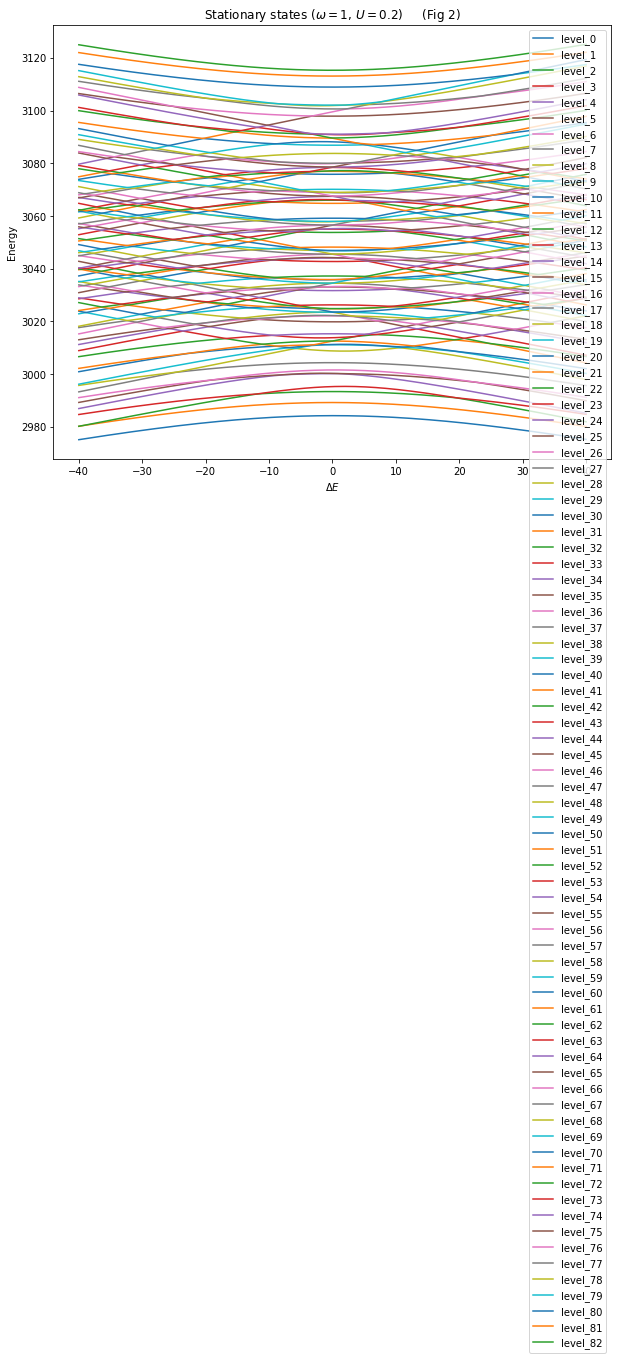

In [200]:
df.plot(x="$\Delta E$",figsize=(10,8),legend=True, 
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");